<center>
<h1 style="color:red; font-size:70px;"> IT-Snow data analysis</h1>

The aim of this notebook is to familiarise with the xarray library, which contains the tools needed to extract information from NetCDF files. In particular, I would like, if possible, to reconstruct the evolution of SWE for the years covered by the IT-SNOW reanalysis. Once I understand the necessary operations, I would like o automate everything with bash scripts. 

In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt

<h1 style="color:blue; font-size:50px;"> Grid problems </h1>

The results of the IT-Snow reanalysis are organised into monthly netCDF files. Each of these objects contains as many snapshots as there are days in that particular month, each of which is “taken” at 11 a.m. and is considered representative of the entire day. The goal, for now, is to be able to print these snapshots so that they can be viewed. At a later stage, I will try to reconstruct the SWE trend for the entire month.

In [2]:
# Opening dataset
dat = xr.open_dataset("y2014/ITSNOW_SWE_201402.nc")
dat

<xarray.Dataset> Size: 2GB
Dimensions:    (crs: 1, Longitude: 2727, Latitude: 2462, time: 28)
Coordinates:
  * crs        (crs) |S1 1B b''
  * Longitude  (Longitude) int64 22kB 6 6 6 6 6 6 6 6 ... 20 20 20 20 20 20 20
  * Latitude   (Latitude) int64 20kB 35 35 35 35 35 35 35 ... 47 47 47 47 47 47
Dimensions without coordinates: time
Data variables:
    Time       (time) datetime64[ns] 224B ...
    SWE        (time, Latitude, Longitude) int64 2GB ...
Attributes: (12/24)
    institution:         CIMA Research Foundation, via Armando Magliotto 2, 1...
    source:              https://doi.org/10.5281/zenodo.6861723
    reference:           https://doi.org/10.5281/zenodo.6861723
    featureType:         n/a
    Conventions:         n/a
    keywords:            Snow, Italy, Reanalysis, SWE, Hydrology
    ...                  ...
    license:             Attribution-NonCommercial 4.0 International, see htt...
    naming_authority:    CIMA Research Foundation
    project:             S3M Italy
    publisher_name:      CIMA Research Foundation, via Zenodo
    publisher_url:       https://www.cimafoundation.org/, via https://doi.org...
    publisher_email:     francesco.avanzi@cimafoundation.org

In [3]:
print(dat.coords)

Coordinates:
  * crs        (crs) |S1 1B b''
  * Longitude  (Longitude) int64 22kB 6 6 6 6 6 6 6 6 ... 20 20 20 20 20 20 20
  * Latitude   (Latitude) int64 20kB 35 35 35 35 35 35 35 ... 47 47 47 47 47 47


As can be seen from the output of the previous code window, the latitude and longitude values are incorrect because they are stored in memory as int64, losing the valuable information provided by the decimal part. In order for the spatial distribution to be reproduced accurately, the coordinates of the dataset must be replaced so that the various grid points are evenly spaced.

In [4]:
# I open the dataset using the open_dataset command. One problem with IT-SNOW files is that 
# the latitude-longitude grid has not been loaded properly, so it is necessary to correct
# this by creating one using the maximum and minimum values provided as metadata.
dat = xr.open_dataset("y2014/ITSNOW_SWE_201402.nc")


# Evaluating grid limits and dimensions
latm = float(dat.attrs['geospatial_lat_min'])
latM = float(dat.attrs['geospatial_lat_max'])
lonm = float(dat.attrs['geospatial_lon_min'])
lonM = float(dat.attrs['geospatial_lon_max'])

n_lat = dat.sizes['Latitude']
n_lon = dat.sizes['Longitude']


# Creating new longitude and latitude datas
newLat = np.linspace(latm, latM, n_lat)
newLon = np.linspace(lonm, lonM, n_lon)


# Using assign_coords to change cooordinates
dat = dat.assign_coords(
    Latitude = newLat,
    Longitude = newLon
)

print("\n--- New dataset structure ---")
dat


--- New dataset structure ---


<xarray.Dataset> Size: 2GB
Dimensions:    (crs: 1, time: 28, Latitude: 2462, Longitude: 2727)
Coordinates:
  * crs        (crs) |S1 1B b''
  * Latitude   (Latitude) float64 20kB 35.15 35.15 35.16 ... 47.58 47.59 47.59
  * Longitude  (Longitude) float64 22kB 6.475 6.48 6.485 ... 20.25 20.26 20.26
Dimensions without coordinates: time
Data variables:
    Time       (time) datetime64[ns] 224B ...
    SWE        (time, Latitude, Longitude) int64 2GB ...
Attributes: (12/24)
    institution:         CIMA Research Foundation, via Armando Magliotto 2, 1...
    source:              https://doi.org/10.5281/zenodo.6861723
    reference:           https://doi.org/10.5281/zenodo.6861723
    featureType:         n/a
    Conventions:         n/a
    keywords:            Snow, Italy, Reanalysis, SWE, Hydrology
    ...                  ...
    license:             Attribution-NonCommercial 4.0 International, see htt...
    naming_authority:    CIMA Research Foundation
    project:             S3M Italy
    publisher_name:      CIMA Research Foundation, via Zenodo
    publisher_url:       https://www.cimafoundation.org/, via https://doi.org...
    publisher_email:     francesco.avanzi@cimafoundation.org

In [5]:
print(dat.coords)

Coordinates:
  * crs        (crs) |S1 1B b''
  * Latitude   (Latitude) float64 20kB 35.15 35.15 35.16 ... 47.58 47.59 47.59
  * Longitude  (Longitude) float64 22kB 6.475 6.48 6.485 ... 20.25 20.26 20.26


<h1 style="color:blue; font-size:50px;"> Plotting problems </h1>

Let us now proceed to plot the spatial distribution of SWE. The main problem encountered in this circumstance is the fact that initially I also printed the fill value, i.e. the numerical value associated with those grid cells where there is no snow cover. 

In [6]:
# Promoting time from variable to coordinate 
if "Time" in dat and "time" in dat.dims and "time" not in dat.coords:
    dat = dat.assign_coords(time=dat["Time"]).drop_vars("Time")

# Selecting SWE (Snow Water Equivalent) and a specific day map
swe = dat["SWE"]                                
map_10feb = swe.sel(time="2014-02-10T00:00:00.000000000")

In [7]:
map_10feb

<xarray.DataArray 'SWE' (Latitude: 2462, Longitude: 2727)> Size: 54MB
[6713874 values with dtype=int64]
Coordinates:
  * Latitude   (Latitude) float64 20kB 35.15 35.15 35.16 ... 47.58 47.59 47.59
  * Longitude  (Longitude) float64 22kB 6.475 6.48 6.485 ... 20.25 20.26 20.26
    time       datetime64[ns] 8B 2014-02-10
Attributes:
    grid_mapping:   crs
    long_name:      Snow Water Equivalent
    standard_name:  Snow Water Equivalent
    units:          mm w.e.

/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)
/home/filippo/.local/lib/python3.10/site-packages/xarray/plot/utils.py:260: RuntimeWarning: overflow encountered in scalar absolute
  vlim = max(abs(vmin - center), abs(vmax - center))


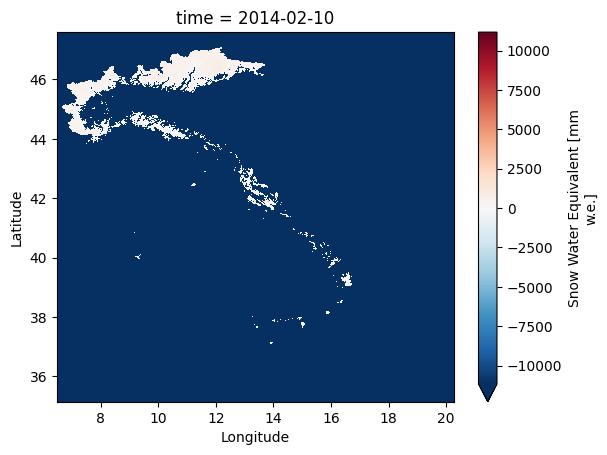

In [8]:
map_10feb.plot(x="Longitude", y="Latitude")

As can be seen from the graph above, all points that do not correspond to snow-covered regions are printed in blue. This means that the vacant values in the water equivalent matrix are filled with a negative fill_value, which in our case is -9999. To ensure that only the extent of the snowpack is printed, we must replace these negative entries with NaN, as this is the only type of data that the plot function does not print, since it cannot be represented.

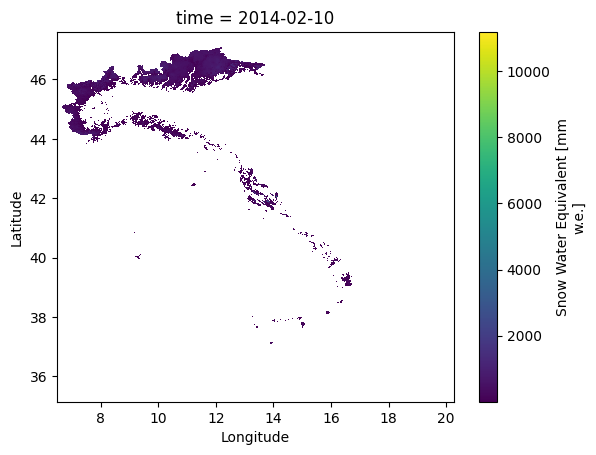

In [9]:
# Changing data type to float32 and creating a mask to select only snow covered pixel
FILL_VALUE = -9999.0

map_10feb = map_10feb.astype(np.float32)
map_10feb = map_10feb.where(map_10feb > FILL_VALUE)
map_10feb.plot(x="Longitude", y="Latitude")

<h1 style="color:blue; font-size:50px;"> Computing total SWE</h1>

The idea now is to sum up all the SWE values and then multiply the total by 2.5 to obtain the total volume of water stored in alpine snow. To do this, I use the previous mask to consider only the positive pixels.

In [11]:
FILL_VALUE = -9999.0
dat = xr.open_dataset("y2014/ITSNOW_SWE_201402.nc")
if "Time" in dat and "time" in dat.dims and "time" not in dat.coords:
    dat = dat.assign_coords(time=dat["Time"]).drop_vars("Time")

swe = dat["SWE"]
timeSWE = dat["time"].values

evoSWE = []

for t in timeSWE:
    maptoS = swe.sel(time=t)

    maptoS = maptoS.astype(np.float32)
    maptoS = maptoS.where(maptoS > FILL_VALUE)

    daySWE = maptoS.sum(skipna=True)
    evoSWE += [daySWE.item()*250/1e9]
    print(f"Total sum is: {daySWE.item()*250/1e9} km^3 we")

/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 15.936052 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 16.273972 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 16.490279 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 16.751792 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 16.799528 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 17.879742 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 17.85239 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 18.935246 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 19.780424 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 19.91712 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 20.933324 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 21.714998 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 21.95581 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 22.685246 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 22.716618 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 22.864628 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 23.496916 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 22.913388 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 23.03257 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 22.893106 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 22.238758 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 22.521652 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 22.647426 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 22.689808 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 22.482032 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 20.623326 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 21.52419 km^3 we


/home/filippo/.local/lib/python3.10/site-packages/xarray/coding/variables.py:424: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype, copy=True)


Total sum is: 21.896402 km^3 we


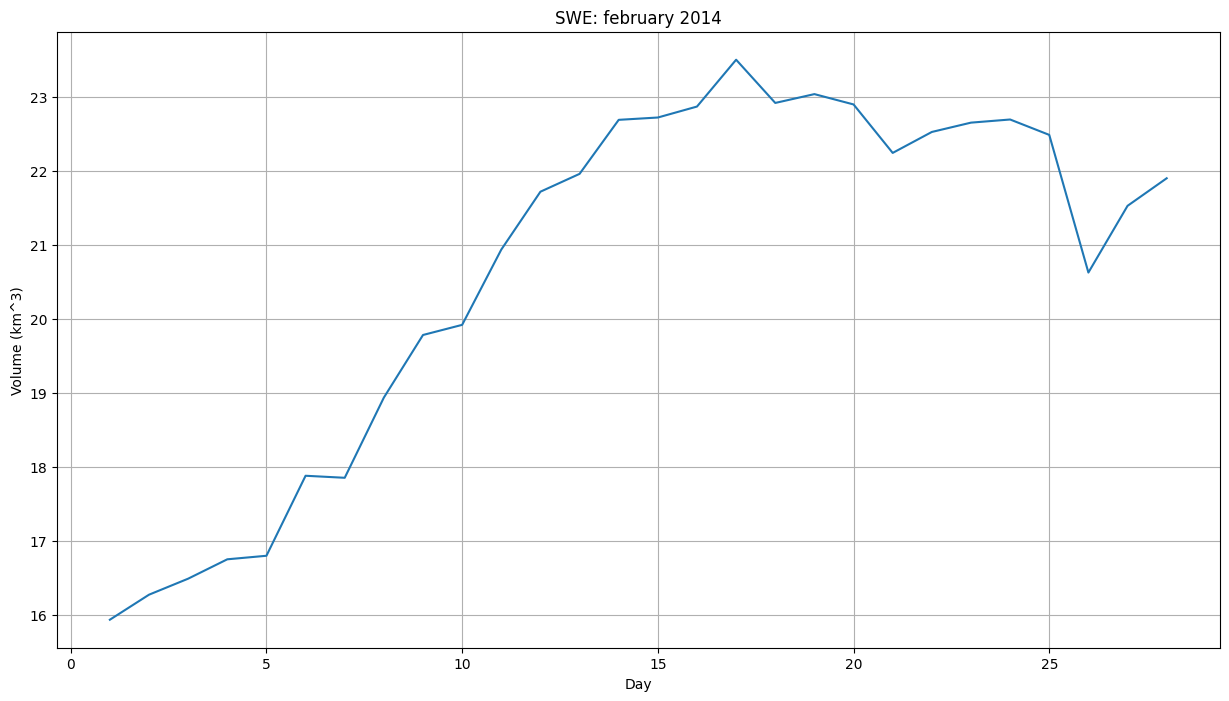

In [12]:
fig = plt.figure(figsize = (15, 8))

plt.plot(np.arange(1, 29, 1), evoSWE)

plt.title("SWE: february 2014")
plt.ylabel("Volume (km^3)")
plt.xlabel("Day")

plt.grid(True)
plt.show()

<h1 style="color:blue; font-size:50px;"> SWE yearly evolution</h1>

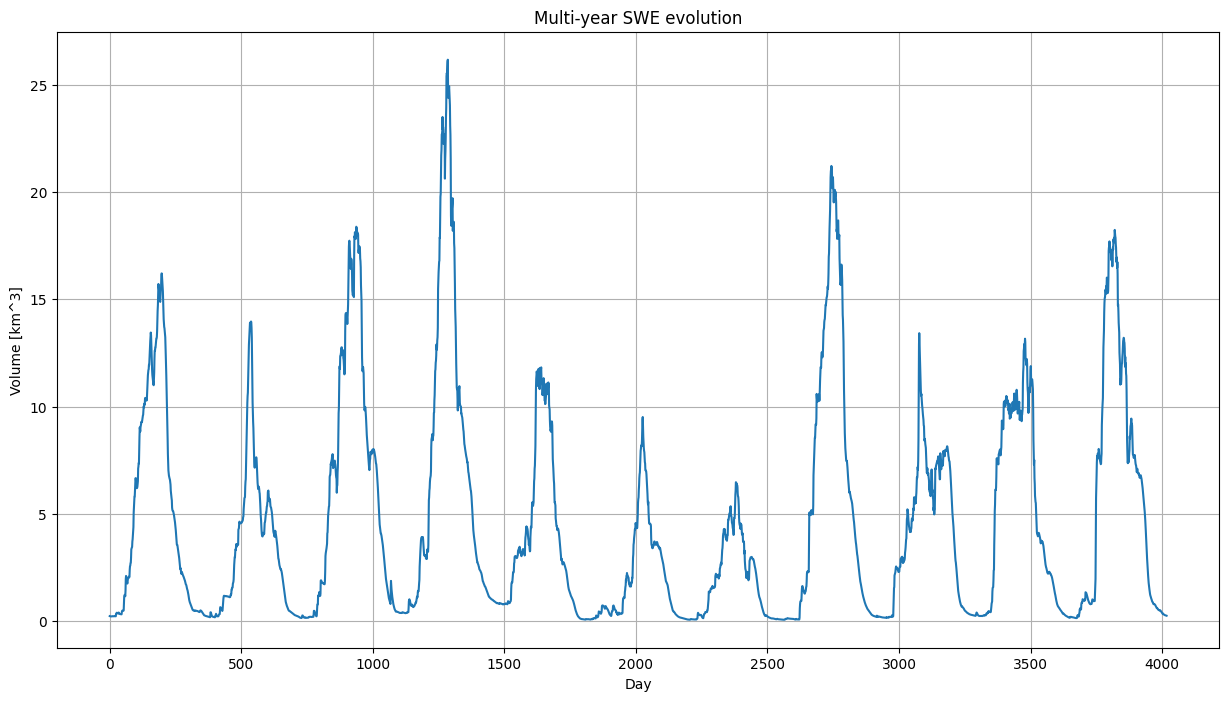

In [13]:
swe = np.loadtxt("recordSWE.dat")

fig = plt.figure(figsize = (15, 8))

plt.plot(swe)

plt.title("Multi-year SWE evolution")
plt.ylabel("Volume [km^3]")
plt.xlabel("Day")

plt.grid(True)
plt.show()